<a href="https://www.kaggle.com/code/fabianforthmann/chess-pieces-identification?scriptVersionId=120463544" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Importing necessary libraries

import numpy as np

import cv2
from sklearn.decomposition import PCA

import plotly.express as px

import random
from random import shuffle

from pprint import pprint
import warnings
import glob
import os

warnings.filterwarnings("ignore") 

# Splitting data for future use
Setting the size for training and testing for easy computing.

Using this sample for all future processes including:
* Data Exploration
* Data Transformation
* Data Preprocessing
* Model Training

In [2]:
train_path = glob.glob("../input/chess-positions/train/*.jpeg")
test_path = glob.glob("../input/chess-positions/test/*.jpeg")

train_size =20000
test_size = 4000

random.shuffle(train_path)
random.shuffle(test_path)

train_data_pathes = train_path[:train_size]
test_data_pathes= test_path[:test_size]

rand_training = random.randint(0, train_size)

# Data Exploration
The key facts of the dataset do not have to be explored because they are documented very well in the dataset:

> 100.000 images of a randomly generated chess positions of 5-15 pieces (2 kings and 3-13 pawns/pieces) Images were generated using 28 styles of chess boards and 32 styles of chess pieces totaling 896 board/piece style combinations.

> **All images are 400 by 400 pixels.**

> **Training set: 80.000 images. Test set: 20.000 images.** 

> **Labels are in a filename in Forsyth–Edwards Notation (FEN) format, but with dashes instead of slashes.**

In [3]:
# Extracting the FEN notation from the file name
def get_FEN_notation(image_path):
    FEN_notation = image_path.split('/')[-1].replace('.jpeg', '').replace('-', '/')
    return FEN_notation


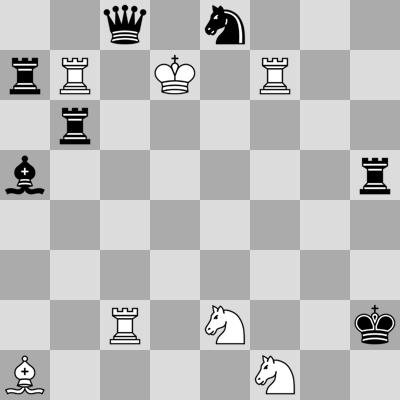

In [4]:
# Showing random sample of the training data
example_image_path = train_data_pathes[rand_training]
example_image = cv2.imread(example_image_path)
FEN_notation_example_image = get_FEN_notation(train_data_pathes[rand_training])
example_figure = px.imshow(example_image, title='FEN notation: ' + FEN_notation_example_image)

example_figure.show()

# Transforming FEN notation for preprocessing and training

The labeling has to be transformed into a structure, where it can be used for training and validation. 

In [5]:
# Understanding FEN notation by using chess library
!pip install chess
import chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 1.1 MB/s eta 0:00:00


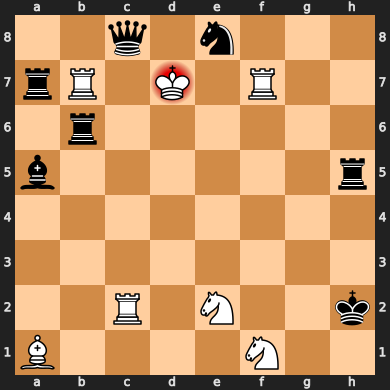

In [6]:
# Showing example in chess library
example_board = chess.Board(FEN_notation_example_image)
example_board

In [7]:
# Exploring possible matrix notation from chess library
print(example_board)
print('\n FEN notation: ' + FEN_notation_example_image)

. . q . n . . .
r R . K . R . .
. r . . . . . .
b . . . . . . r
. . . . . . . .
. . . . . . . .
. . R . N . . k
B . . . . N . .

 FEN notation: 2q1n3/rR1K1R2/1r6/b6r/8/8/2R1N2k/B4N2


Using following symbols for encoding the chess pieces: **prbnkq & PRBNKQ**

* r: Rook/Turm
* n: Knight/Springer
* b: Bishop/Läufer
* q: Queen/Damen
* k: King/König 
* p: Pawn/Bauer

Lowerkace: black figures, uppercase: white figures.

In [8]:
# Additional idea: Adding one-hot-encoding for chess pieces at position for easy computing
# Also for presenting and comparing the results, a decoder could be usefull

def fen_to_array_encoder(fen):
    board = []
    for row in fen.split('/'):
        brow = []
        for c in row:
            if c == '':
                break
            elif c in '12345678':
                brow.extend(['__'] * int(c))
            elif c == 'p':
                brow.append('bp')
            elif c == 'P':
                brow.append('wp')
            elif c > 'Z':
                brow.append('b'+c.upper())
            else:
                brow.append('w'+c)

        board.append(brow)
    return np.array(board)

pprint(fen_to_array_encoder(FEN_notation_example_image))

array([['__', '__', 'bQ', '__', 'bN', '__', '__', '__'],
       ['bR', 'wR', '__', 'wK', '__', 'wR', '__', '__'],
       ['__', 'bR', '__', '__', '__', '__', '__', '__'],
       ['bB', '__', '__', '__', '__', '__', '__', 'bR'],
       ['__', '__', '__', '__', '__', '__', '__', '__'],
       ['__', '__', '__', '__', '__', '__', '__', '__'],
       ['__', '__', 'wR', '__', 'wN', '__', '__', 'bK'],
       ['wB', '__', '__', '__', '__', 'wN', '__', '__']], dtype='<U2')


# Preprocessing data for model training
For better training the pictures are preprocessed with two methods: 

* Resizing to 240x240 pixels
* PCA 

With those methods the most important informations of the board-pictures are obtained while reducing noise.
Other preprocessing steps could include: 

* Normalizing color of images
* Drawing visible borders between the single fields
* Seperating single fileds for single training*

In [9]:
# Making asjustments as described
def preprocess_image(image_path):
    
    image = cv2.imread(image_path)
    
    # Downsizing the image
    resized_image = cv2.resize(image, (240, 240))
    
    # Dimensionality reduction using PCA from skitlearn
    blue,green,red = cv2.split(resized_image) 
    
    pca = PCA(30)
    
    red_transformed = pca.fit_transform(red)
    red_inverted = pca.inverse_transform(red_transformed)
 
    green_transformed = pca.fit_transform(green)
    green_inverted = pca.inverse_transform(green_transformed)
 
    blue_transformed = pca.fit_transform(blue)
    blue_inverted = pca.inverse_transform(blue_transformed)
    
    compressed_image = (np.dstack((red_inverted, red_inverted, red_inverted))).astype(np.uint8)
    
    return compressed_image


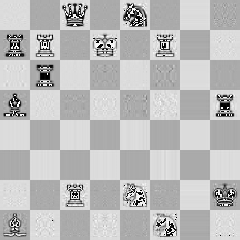

In [10]:
# Showing downsized and compressed example image
preprocessed_example_figure = px.imshow(preprocess_image(example_image_path), title='Downsized and compressed example image; 240x240 pixels')
preprocessed_example_figure.show()

# Developing model

The pictures will be processed using a **Convolutional Neural Network**. Therefore the layers of the network will be oriented on the strukture of the labels. 

The solution **- an automatic classification of the FEN-notation -** will be developed stepwise: 
1. Identification of single pieces
2. Identification of certain combinations
3. Identification of all possible combinations

Therefore the training pictures will be filtered using the given FEN-notation. This approach allows us to reevaluate our training in less complex steps.